### 🔍 3D 밀도 필드 비교 시각화 (True vs Base vs UNet vs ViT)

이 셀은 동일한 위치의 3D 밀도 필드 ρ(x,y,z)에 대해  
**True (시뮬레이션 정답)**, **Base baseline**, **UNet**, **ViT** 예측을  
**동일한 스케일에서 직접 비교**하기 위한 시각화입니다.

#### ✅ 처리 흐름
1. HDF5/NPY에서 데이터를 불러옵니다.
2. 입력 형태가 `(N,C,D,H,W)` 또는 `(H,W,D)`일 수 있으므로  
   → 모두 `(D,H,W)` 형태로 정규화합니다.
3. Base 결과는 학습 시 `log10(ρ)/2.5`였으므로  
   → `10**(2.5*x)` 로 **ρ** 로 복원합니다.
4. Z축(D)을 기준으로 평균 투영하여 `(H,W)` 2D 맵으로 변환합니다.
5. 대비를 보기 쉽게 `log1p(ρ)` 변환을 적용합니다.
6. 네 이미지 모두에서 **동일 퍼센타일 기반 색상 스케일(vmin/vmax)** 을 사용하여  
   → 공정 비교가 가능하도록 합니다.
7. 모든 subplot에 대해 **하나의 공통 colorbar** 를 사용합니다.

#### ⚠️ 주의할 점
- `to_DHW()`는 축 자동 추론을 사용하므로,  
  **데이터 포맷이 확정되어 있다면 명시적 transpose가 더 안전합니다.**
- base가 `(log10(1+δ))/2.5` 기반이라면  
  → 복원식이 `10**(2.5*x) - 1` 로 달라질 수 있습니다.
- 시각화만으로 판단하기 보다는  
  `corrcoef`, `MSE`, 차이맵 등을 함께 확인하는 것이 좋습니다.



  true | shape=(128, 128, 128)  min=0.0394  max=378  mean=1
  base | shape=(128, 128, 128)  min=0.0813  max=88.4  mean=0.784
  unet | shape=(128, 128, 128)  min=0  max=188  mean=1
   vit | shape=(128, 128, 128)  min=-0.14  max=231  mean=0.959


/tmp/ipykernel_3651864/546066229.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cividis")
/tmp/ipykernel_3651864/546066229.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


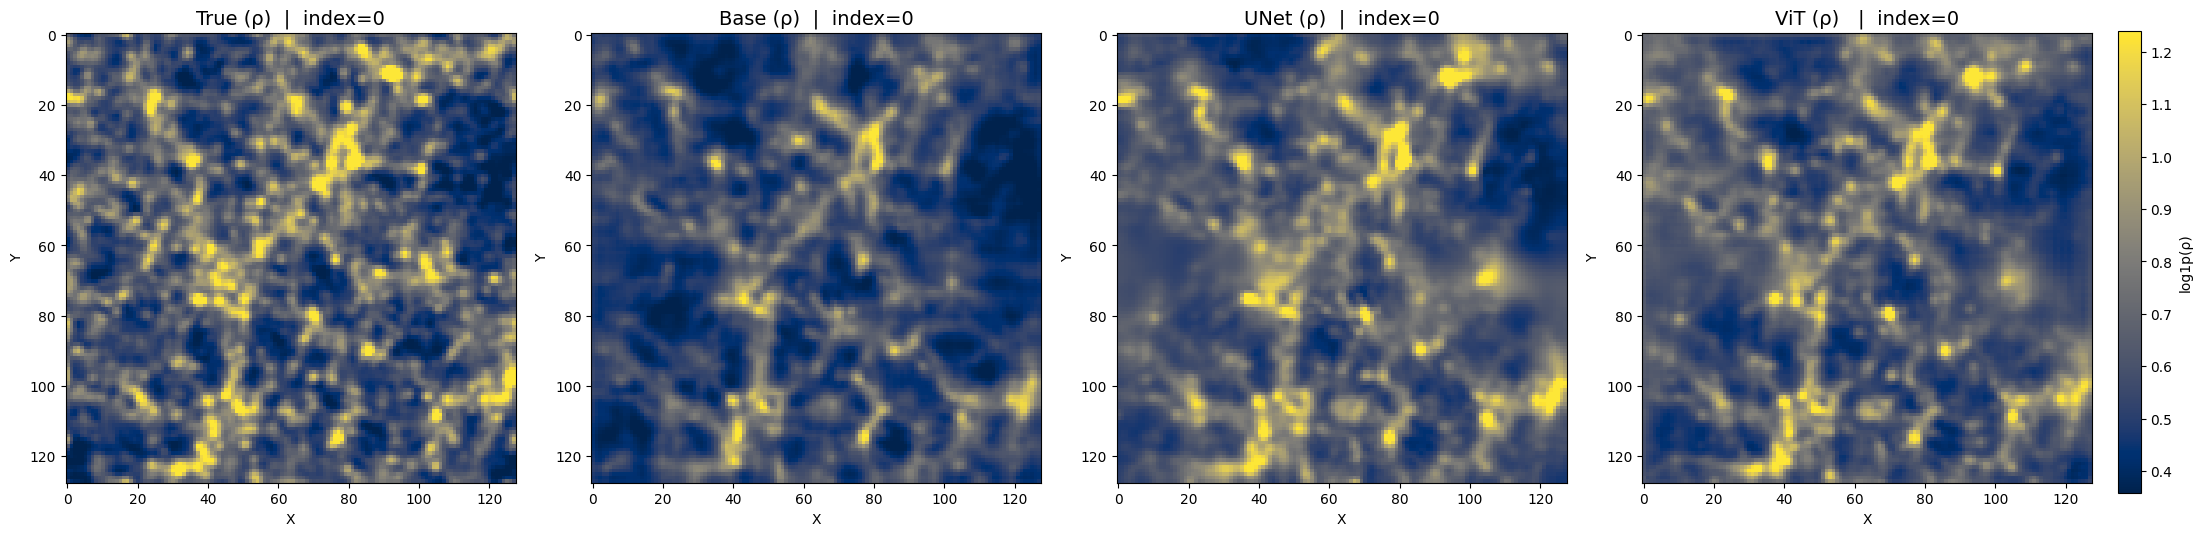

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # [중요] cmap/mappable용
from typing import Tuple

def to_DHW(a: np.ndarray) -> np.ndarray:
    """
    입력 배열을 (D,H,W)로 표준화.
    허용 형태: (D,H,W), (H,W,D), (C,D,H,W), (N,C,D,H,W), (N,D,H,W)
    주의: '가장 긴 축이 D'라는 휴리스틱을 사용하므로, 데이터 스펙을 알고 있으면
         명시적 transpose(예: a.transpose(2,0,1))가 더 안전합니다.
    """
    a = np.asarray(a)
    # 앞쪽의 길이 1인 축(N=1, C=1 등)을 최대 2회 제거
    while a.ndim > 3 and a.shape[0] == 1:
        a = a[0]
    while a.ndim > 3 and a.shape[0] == 1:
        a = a[0]

    if a.ndim == 5:          # (N,C,D,H,W) -> 첫 샘플, 첫 채널 선택
        a = a[0, 0]
    elif a.ndim == 4:        # (N,D,H,W) or (C,D,H,W)
        a = a[0]
    elif a.ndim != 3:
        raise ValueError(f"Unsupported shape: {a.shape}")

    # (H,W,D) 케이스 추정: 최댓값인 축이 마지막이면 (2,0,1)로 transpose
    # (데이터 사양을 알면 여기를 고정 transpose로 바꾸세요.)
    if a.shape[2] == max(a.shape) and a.shape[0] != max(a.shape):
        a = a.transpose(2, 0, 1)  # (H,W,D) -> (D,H,W)

    return a  # (D,H,W) 가정

# ----------------- 사용자 설정 -----------------
index = '0'  # 문자열/정수 모두 가능(파일명에 맞춤)
base_path = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/"
unet_pred_path = "/home/mingyeong/GAL2DM_ASIM_VNET/results/unet_predictions/28845/icase-both-keep2"
vit_pred_path  = "/home/mingyeong/GAL2DM_ASIM_ViT/results/vit_predictions/28846/icase-both"
true_test_path = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{index}.hdf5"
# ------------------------------------------------

# ---- 데이터 로드 ----
with h5py.File(true_test_path, 'r') as f:
    rho_true = f['output_rho'][:]      # 타깃: 실제 밀도 ρ

with h5py.File(f"{unet_pred_path}/{index}.hdf5", 'r') as f:
    rho_pred_unet = f['prediction'][:] # UNet 예측 (ρ로 학습했다면 추가 변환 불필요)

with h5py.File(f"{vit_pred_path}/{index}.hdf5", 'r') as f:
    rho_pred_vit = f['prediction'][:]  # ViT 예측

# base_raw가 log10(ρ)/2.5 형식이라고 '가정' -> ρ로 역변환
base_raw = np.load(
    f"{base_path}test_{index}_final_mode0_lr_min1e-07_max1e-05_200epochs_rho_240712_a100_cmb_f2.5.npy"
)
rho_base = 10**(2.5 * base_raw)
# ⚠️ 만약 base가 log10(1+δ)/2.5였다면:
# rho_base = (10**(2.5 * base_raw) - 1) * rho_true.mean()

# ---- (D,H,W)로 표준화 ----
rho_true      = to_DHW(rho_true)
rho_pred_unet = to_DHW(rho_pred_unet)
rho_pred_vit  = to_DHW(rho_pred_vit)
rho_base      = to_DHW(rho_base)

# ---- 기본 통계/유효값 체크(빠른 sanity) ----
def stats(name, a):
    print(f"{name:>6s} | shape={a.shape}  "
          f"min={a.min():.3g}  max={a.max():.3g}  mean={a.mean():.3g}")
for n, a in [("true", rho_true), ("base", rho_base),
             ("unet", rho_pred_unet), ("vit", rho_pred_vit)]:
    stats(n, a)
    assert np.isfinite(a).all(), f"{n} contains NaN/Inf"

# ---- 투영(평균) + log1p(ρ) ----
proj = lambda x: x.mean(axis=0)  # (D,H,W)->(H,W). 단층(slice)을 보고 싶으면 x[D//2] 등 사용.
P_true = np.log1p(proj(rho_true))
P_base = np.log1p(proj(rho_base))
P_unet = np.log1p(proj(rho_pred_unet))
P_vit  = np.log1p(proj(rho_pred_vit))

# ---- 공통 컬러스케일(norm) 계산 ----
imgs = [P_true, P_base, P_unet, P_vit]
stack = np.concatenate([im.ravel() for im in imgs])
vmin, vmax = np.percentile(stack, [1, 99])  # 극단치 배제(필요 시 0.5–99.5 등 조정)

cmap = cm.get_cmap("cividis")
norm = plt.Normalize(vmin=vmin, vmax=vmax)  # [중요] 4개 패널에 공통 적용

# ---- 시각화 ----
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
titles = [
    f"True (ρ)  |  index={index}",
    f"Base (ρ)  |  index={index}",
    f"UNet (ρ)  |  index={index}",
    f"ViT (ρ)   |  index={index}",
]

for i, im in enumerate(imgs):
    ax[i].imshow(im, cmap=cmap, norm=norm)
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel("X"); ax[i].set_ylabel("Y")

# 단일 mappable로 공통 colorbar 생성(개별 축에 종속되지 않게)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])

fig.colorbar(mappable, ax=ax.ravel().tolist(),
             fraction=0.02, pad=0.04, label="log1p(ρ)")

# 여백 조정(우측 colorbar 확보)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()
